In [1]:
'''
very simple CNN for MNIST 
based on
https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py
'''

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

from keras.optimizers import SGD, Adam

from keras import backend as K


import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import numpy as np

from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
# input image dimensions
img_rows, img_cols = 28, 28

# this is fixed, we have 10 digits in our data set
num_classes = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## X_train is of shape n_samples x 28 x 28
## for a CNN we want to keep the image shape
## need to explicitly tell keras that it is a gray value image
## so each image is 28x28x1 not 28x28x3
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# normalize image values to [0,1]
# interestingly the keras example code does not center the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
# keras likes one hot encoding instead of class names
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 256
# number of iterations over the complete training data
epochs = 50

for n_conv_layers in [1,2]:
    for n_dense_layers in [1,2]:
        log_dir_string = "cv"
        K.clear_session()
        model = Sequential()
        model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        if n_conv_layers == 1:
            log_dir_string += "_1conv"
        else:
            model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            log_dir_string += "_2conv"
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        if n_dense_layers == 1:
            log_dir_string += "_1fc"
        else:
            model.add(Dense(64, activation='relu'))
            log_dir_string += "_2fc"
        
        model.add(Dense(num_classes, activation='softmax'))

        adam = Adam(lr=0.001)
        model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

        # we need a callback to save information for tensorboard visualizations
        tensorboard = TensorBoard(log_dir='./logs/cv/'+log_dir_string, histogram_freq=1, write_graph=True, write_images=False)

        history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[tensorboard])


        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.
INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.
Epoch 1/50
60000/60000 [==============================] - 29s - loss: 0.3431 - acc: 0.9046 - val_loss: 0.1322 - val_acc: 0.9616
Epoch 2/50
60000/60000 [==============================] - 26s - loss: 0.1002 - acc: 0.9710 - val_loss: 0.0718 - val_acc: 0.9767
Epoch 3/50
60000/60000 [==============================] - 25s - loss: 0.0693 - acc: 0.9800 - val_loss: 0.0554 - val_acc: 0.9823
Epoch 4/50
60000/60000 [==========

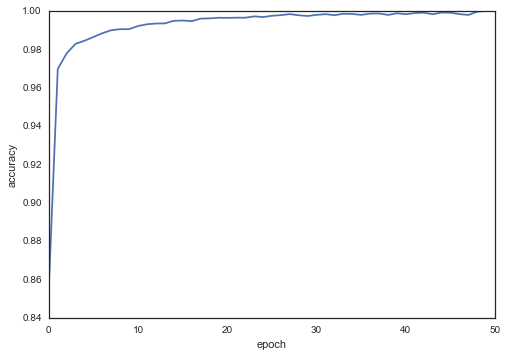

In [4]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")


In [5]:
# Look at the weights of the first layer
layer = model.layers[0]
# this actually returns a list 
# first element is W
# second element are all the biases b
weights = layer.get_weights()
# the weights are the number of pixels times the number of filters (hidden units)
print("Shape of W")
print(weights[0].shape)

Shape of W
(5, 5, 1, 16)


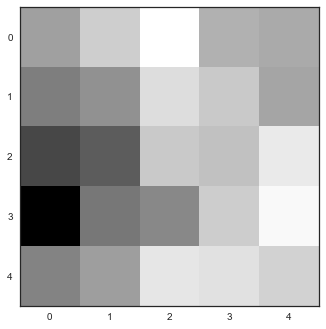

In [6]:
# look at just the first filter
w = weights[0][:,:,0,0]
w = w.reshape((5,5))
plt.imshow(w, cmap='gray')

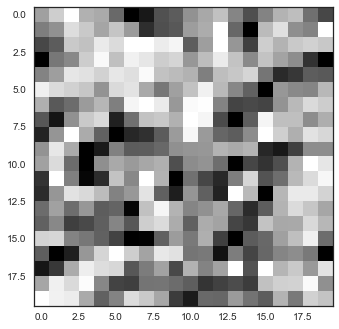

In [7]:
# make a figure for the first 25 filters
filterTiles = np.array([])
index = 0
for i in range(4):
    filterRow = []
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        w = w-np.min(w)
        w = w / np.max(w)
        filterRow.extend(w)
        index+=1
    filterRow = np.array(filterRow)
    if not filterTiles.shape[0] == 0:
        filterTiles = np.hstack([filterTiles, filterRow])
    else:
        filterTiles = filterRow

plt.imshow(filterTiles, cmap='gray')    
plt.show()

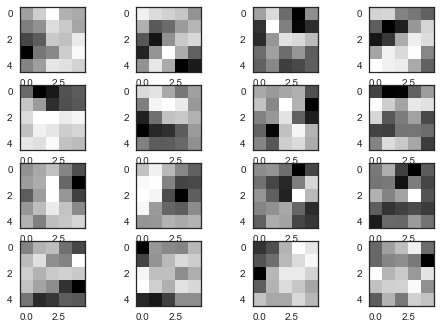

In [8]:
# make a figure for the first 25 filters
index = 0
for i in range(4):
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        index+=1
        plt.subplot(4,4,index)
        plt.imshow(w, cmap='gray')    

plt.show()